<a href="https://colab.research.google.com/github/Ibilis37/DSP_/blob/main/%D0%9C%D0%9E%D0%A6%D0%9E%D0%A1_3__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Лабораторная работа №3
#### Комольцева Диана ПМ-32
### Вариант 1

### Задание 1
Синтезировать нерекурсивный симметричный фильтр порядка N=2M

(КИХ-фильтр с линейной фазой типа I, с ЧХ (4.1) с
заданной в таблице вариантов полосой пропускания, аналогично
решению примера 4.2).

 Построить амплитудно-частотную и
фазочастотную характеристики. Сравнить полученную АЧХ с
идеальной.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import freqz
from scipy.optimize import minimize
from scipy.signal import filtfilt
from PIL import Image
import cv2

In [20]:
# параметры фильтра
w_p = [0, 0.6*np.pi]
w_s = [0.8*np.pi,np.pi]
M = 5  # M
N = 2*M
w_j = np.pi * (np.arange(M+1) + 0.5)/(M + 1)
K_d = (w_j >= w_p[0]) & (w_j < w_p[1])
w_0 = -2*np.pi
w_n = 2*np.pi
w = np.arange(w_0, w_n+0.01, 0.01)

In [21]:
# вычисление коэффициентов фильтра
def find_coef(M, K_d):
  h = np.zeros(M+1)
  for k in range(M+1):
      for j in range(M+1):
          h[M - k] +=  np.abs(K_d[j]) * np.cos(np.pi * k * (2*j + 1) / (2*(N + 1)))/(M + 1)
  return h

# идеальный набор коэффициентов фильтра
def IdealFilter(w_p, N):
    b1 = np.ceil(w_p[0] * (N + 1) /np.pi - 0.5).astype(int)
    b2 = np.floor(w_p[1] * (N + 1) / np.pi - 0.5).astype(int)
    kd = np.zeros(N + 1)
    val = np.arange(b1 + 1, b2 + 1)
    kd[val] = np.ones(len(val))
    kd[0] = 1
    return kd
# АЧХ
def AFR(h, w, M):
  A = np.zeros(len(w))
  for i in range(len(w)):
      A[i] = h[M]
      for k in range(1,M+1):
          A[i] += 2*h[M - k] * np.cos(w[i] * k)
  return A
# идеальная характеристика фильтра
def IdealResponse(w, w_0):
    r = np.zeros(len(w_0))
    for i in range(len(w_0)):
        pos = np.sign(w_0[i]) * (np.mod(np.abs(w_0[i]) + np.pi, 2 * np.pi) - np.pi)
        pos = np.abs(pos)
        if (pos >= w[0]) and (pos < w[1]):
            r[i] = 1
        else:
            r[i] = 0
    return r


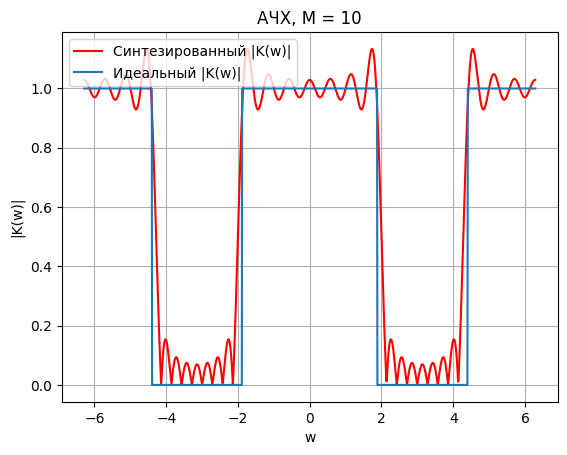

In [22]:
f = find_coef(N, IdealFilter(w_p, N))
afr = AFR(f, w, N)
plt.figure()
plt.plot(w, np.abs(afr), 'r')
plt.plot(w, IdealResponse(w_p, w))
plt.legend(['Синтезированный |K(w)|', 'Идеальный |K(w)|'], loc='upper left')
plt.xlabel('w')
plt.ylabel('|K(w)|')
plt.title(f'АЧХ, M = {N}')
plt.grid(True)
plt.show()

In [23]:
# логарифмическая шкала коэффициентов фильтра
def LogFR(K_d):
    r = np.zeros(len(K_d))
    for i in range(len(K_d)):
        if K_d[i] < 10**(-7):
            r[i] = 10**(-7)
        else:
            r[i] = K_d[i]
    r = 20 * np.log10(r)
    return r

# удваиваем и центрируем вектор b
def Double(b, N):
    B = np.zeros(2 * N + 1)
    for k in range(N + 1):
        B[N + k] = b[N-k]
        B[N - k] = b[N-k]
    return B

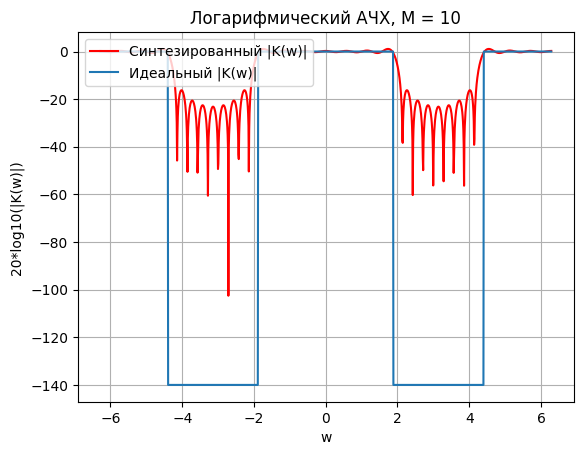

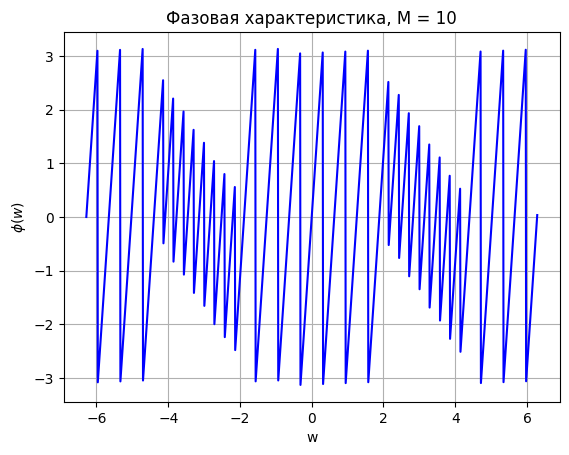

In [24]:
plt.figure()
plt.plot(w, LogFR(np.abs(afr)), 'r')
plt.plot(w, LogFR(IdealResponse(w_p, w)))
plt.legend(['Синтезированный |K(w)|', 'Идеальный |K(w)|'], loc = 'upper left')
plt.xlabel('w')
plt.ylabel('20*log10(|K(w)|)')
plt.title(f'Логарифмический АЧХ, M = {N}')
plt.grid(True)

plt.figure()
f_2 = Double(f, N)
plt.plot(w, -np.angle(freqz(f_2, 1, w))[1], 'b')
plt.xlabel('w')
plt.ylabel(r'$ \phi(w) $')
plt.title(f'Фазовая характеристика, M = {N}')
plt.grid(True)
plt.show()

**Вывод:** По графикам видно, что АЧХ фильтра стремится к идеальной характеристике, однако вблизи точек разрыва возникает осциляция из-за эффекта Гиббса.


### Задание 2
 Реализовать функцию синтеза фильтра (т.е. нахождения
коэффициентов {bk} (k=0,..., 2M)), которая обеспечивает наилучшее
равномерное приближение заданной АЧХ по методу на основе
частотной выборки и принимает в качестве аргументов:
* Положение полосы пропускания проектируемого фильтра на оси
𝛚
* Положение полосы подавления проектируемого фильтра на оси
𝛚
* Параметр M

С помощью реализованной функции синтезировать фильтр того же
порядка N = 2M, что и в п. 1.

Сравнить полученную АЧХ с идеальной и с АЧХ, найденной в п. 1.
Для решения задачи оптимизации, возникающей при синтезе
КИХ-фильтра на основе частотной выборки, можно использовать
встроенные функции MATLAB, например, fmincon, fminsearch.


In [6]:
def A_w(w, h, M):
    a_w = h[M]
    for k in range(1, M + 1):
        a_w += 2 * h[M - k] * np.cos(w * k)
    return a_w

def syntez(x_j, w_p, w_s, M):
    w_j = np.pi * (np.arange(M + 1) + 0.5) / (M + 1)
    flag_pass = (w_j > w_p[0]) & (w_j <= w_p[1])
    flag_stop = (w_j >= w_s[0]) & (w_j < w_s[1])
    K_d = np.zeros_like(w_j)
    K_d[flag_stop] = 0
    K_d[flag_pass] = 1
    K_d[~(flag_stop | flag_pass)] = x_j
    h = np.zeros(M + 1)

    for k in range(M + 1):
        for j in range(M + 1):
            h[M - k] += K_d[j] * np.cos(w_j[j] * k)/ (M + 1)

    E = []
    eps = 0.001
    for i in np.arange(w_s[0], w_s[1], eps):
        E.append(-A_w(i,h,M))
    for i in np.arange(w_p[0], w_p[1], eps):
        E.append(1 - A_w(i,h,M))
    error = max(np.abs(E))
    return error, h

# для оптимизатора
def opt_syntez(x, w_p, w_s, M):
    error, _ = syntez(x, w_p, w_s, M)
    return error

In [ ]:
x_j = [0.0,0.0]
w_j = np.pi * (np.arange(M + 1) + 0.5) / (M + 1)
error, h = syntez(x_j, w_p, w_s, M)
print("error:", error)
print("h:", h)

# оптимизация
result = minimize(opt_syntez, x_j, args=(w_p, w_s, M), method='Nelder-Mead')
opt_x = result.x

# фильтр с оптимизированными параметрами
error, h = syntez(opt_x, w_p, w_s, M)
print("error:", error)
print("h:", h)

error: 0.9203337279763125
h: [-6.37244474e-02 -4.85722573e-17  7.51681109e-02 -2.77555756e-17
 -1.12497028e-01  1.38777878e-17  3.20364431e-01  5.00000000e-01]
error: 0.055022778454826726
h: [ 0.03423526 -0.02991225 -0.02035369  0.06913275 -0.03688264 -0.10843802
  0.29088501  0.6254927 ]


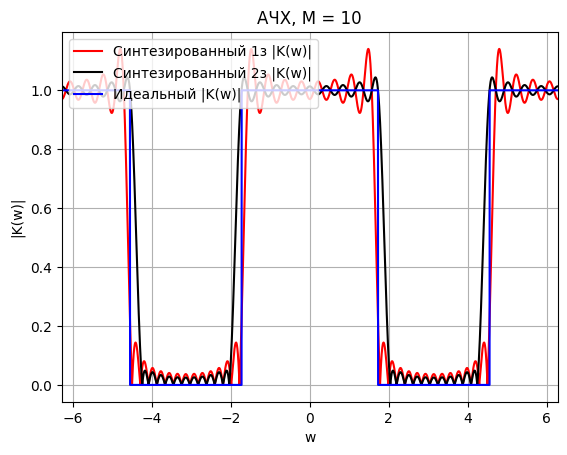

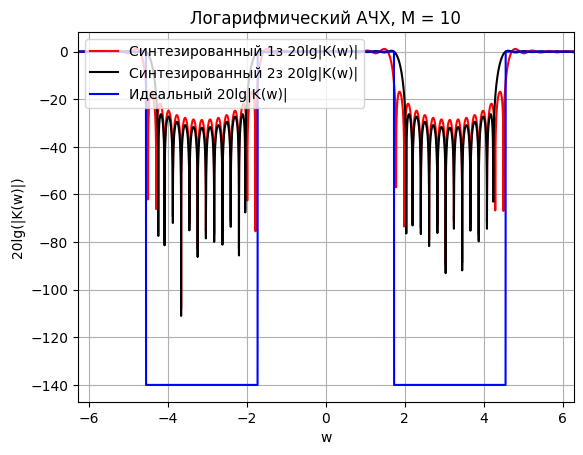

Погрешность АЧХ
Погрешность идеального и п1. 0.23752532322283137
Погрешность идеального и п2. 0.03735501043442213


In [23]:
plt.figure()
f1 = find_coef(N, IdealFilter(w_p, N))
ach1 = AFR(f1, w, N)
plt.plot(w, np.abs(ach1), 'r')

_ , f2 = syntez(opt_x, w_p, w_s, N)
ach2 = AFR(f2, w, N)
plt.plot(w, np.abs(ach2), 'black')

f3 = IdealResponse(w_p, w)
plt.plot(w, f3, 'b')

plt.xlim(w0, wn)
plt.xlabel('w')
plt.ylabel('|K(w)|')
plt.title(f'АЧХ, M = {N}')
plt.legend(['Синтезированный |K(w)|', 'Оптимальный |K(w)|', 'Идеальный |K(w)|'],loc = 'upper left')
plt.grid()

plt.figure()
plt.plot(w, LogFR(np.abs(ach1)), 'r')
plt.plot(w, LogFR(np.abs(ach2)), 'black')
plt.plot(w, LogFR(np.abs(f3)), 'b')
plt.xlim([w0, wn])
plt.legend(['Синтезированный |K(w)|', 'Оптимальный |K(w)|', 'Идеальный |K(w)|'], loc = 'upper left')
plt.xlabel('w')
plt.ylabel('20lg(|K(w)|)')
plt.title(f'Логарифмический АЧХ, M = {N}')
plt.grid(True)
plt.show()

flag_3 = np.where(filt3==0)
print("Погрешность АЧХ")
print(f"Погрешность идеального и п1. {np.linalg.norm(filt3[:flag_3[0][0]-100]-np.abs(ach1[:flag_3[0][0]-100]),ord = np.inf)}")
print(f"Погрешность идеального и п2. {np.linalg.norm(filt3[:flag_3[0][0]-100]-np.abs(ach2[:flag_3[0][0]-100]),ord = np.inf)}")

**Вывод:** Погрешность оптимального фильтра меньше ошибки фильтра из первого задания

### Задание №3
Проверить, удовлетворяет ли фильтр, синтезированный в п. 2,
требованиям к неравномерности АЧХ в полосах пропускания и
подавления при заданных параметрах 𝛅p и 𝛅s.

Определить
минимальный порядок фильтра (N=2M), удовлетворяющего данным
требованиям.



In [27]:
dp = 0.0125
ds = 0.015
w_p = [0, 0.6*np.pi]
w_s = [0.8*np.pi,np.pi]
for N in range(1, 30):
    w_j = np.pi * (np.arange(N + 1) + 0.5) / (N + 1)
    flag_pass = (w_j > w_p[0]) & (w_j <= w_p[1])
    flag_stop = (w_j >= w_s[0]) & (w_j < w_s[1])
    K_d = np.zeros_like(w_j)
    x_j = sorted(np.random.uniform(0,1, len(K_d[~(flag_stop | flag_pass)])))
    result = minimize(opt_syntez, x_j, args=(w_p, w_s, N), method='Nelder-Mead')
    opt_x = result.x
    error, h = syntez(opt_x, w_p, w_s, N)
    if (error <= dp) and (error <= ds):
        print(f'Минимальный порядок N = 2M : {N}')
        break

Минимальный порядок N = 2M : 12


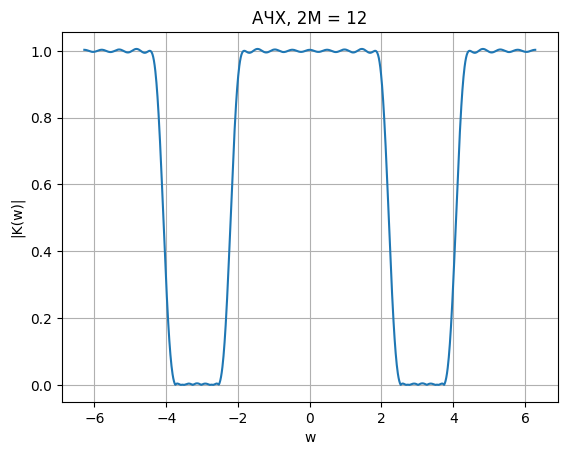

In [28]:
N = 12
w_j = np.pi * (np.arange(N + 1) + 0.5) / (N + 1)
flag_p = (w_j > w_p[0]) & (w_j <= w_p[1])
flag_s = (w_j >= w_s[0]) & (w_j < w_s[1])
K_d = np.zeros_like(w_j)
x_j = sorted(np.random.uniform(0.1,0.9,len(K_d[~(flag_s | flag_p)])))
result = minimize(opt_syntez, x_j, args=(w_p, w_s, N), method='Nelder-Mead')
opt_x = result.x
err, h = syntez(opt_x, w_p, w_s, N)

afr = AFR(h, w, N)
plt.plot(w, np.abs(afr))
plt.title("АЧХ, 2M = 12")
plt.xlabel('w')
plt.ylabel('|K(w)|')
plt.grid()

**Вывод:** по графику заметим, что, действительно, при порядке фильтра N=12  явление Гиббса не происходит

### Задание 4
С помощью синтезированного в п. 2 фильтра обработать сигналы
x(n)=sin(𝛚n) для указанных в таблице вариантов значений 𝛚.


Определить задержку 𝛼 гармонического колебания на выходе
фильтра.

Omega: 0.30π
Задержка: 0


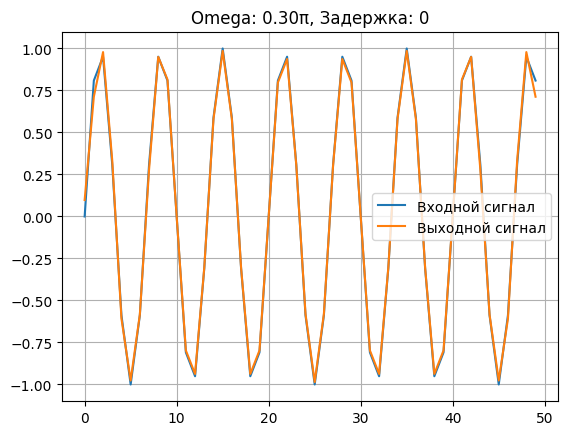

Omega: 0.50π
Задержка: 4


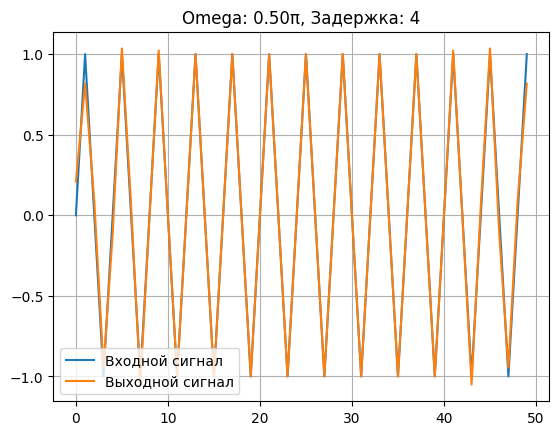

Omega: 0.80π
Задержка: -3


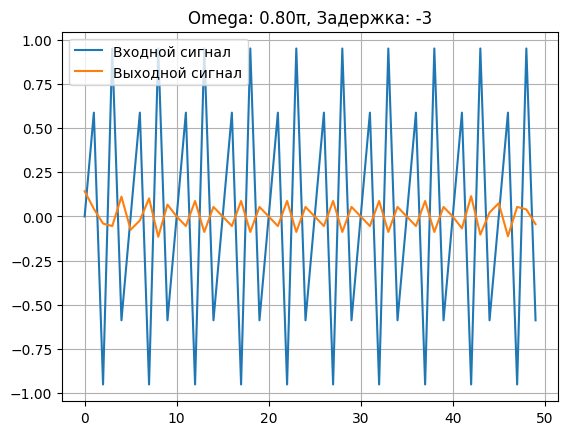

In [29]:
w_p = [0, 0.6*np.pi]
w_s = [0.8*np.pi,np.pi]
M = 5
N = 2*M
x_j = [0.0,0.0]
result = minimize(opt_syntez, x_j, args=(w_p, w_s, N), method='Nelder-Mead')
opt_x = result.x
_ , f = syntez(opt_x, w_p, w_s, N)

ff = f[::-1]
ff = np.hstack((ff[::-1], ff[1::]))
n = np.arange(50)
W = [0.3*np.pi,0.5*np.pi,0.8*np.pi]
for omega in W:
    x = np.sin(omega * n)
    y = signal.fftconvolve(x, ff, mode='same')

    # Определение задержки
    delay = np.argmax(y) - np.argmax(x)
    print(f"Omega: {omega / np.pi:.2f}π")
    print(f"Задержка: {delay}")

    plt.figure()
    plt.plot(n, x, label='Входной сигнал')
    plt.plot(n, y, label='Выходной сигнал')
    plt.title(f'Omega: {omega / np.pi:.2f}π, Задержка: {delay}')
    plt.legend()
    plt.grid()
    plt.show()

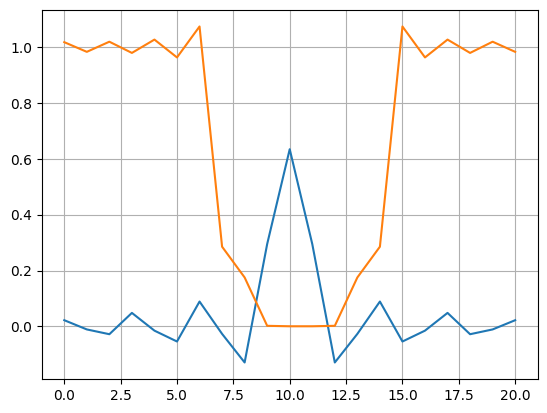

In [44]:
plt.plot(ff)
plt.plot(np.abs(np.fft.fft(ff)))
plt.grid(True)

### Задание 5

С помощью синтезированного в п. 3 фильтра провести фильтрацию
тестового изображения - матрицы I из лабораторной работы 1
(согласно варианту).

 Для этого профильтровать последовательно
каждую строку, затем каждый столбец изображения.

Воспроизвести
полученное изображение J и объяснить полученный результат.


In [32]:
hh = h[::-1]
hh = np.hstack((hh[::-1],hh[1::]))
hh

array([ 5.12402826e-03, -5.90166523e-03, -6.40684132e-04,  1.21657053e-02,
       -1.84417282e-02,  7.12891276e-03,  2.23949352e-02, -4.91916956e-02,
        3.88027597e-02,  3.10047895e-02, -1.45770171e-01,  2.54380039e-01,
        7.00998040e-01,  2.54380039e-01, -1.45770171e-01,  3.10047895e-02,
        3.88027597e-02, -4.91916956e-02,  2.23949352e-02,  7.12891276e-03,
       -1.84417282e-02,  1.21657053e-02, -6.40684132e-04, -5.90166523e-03,
        5.12402826e-03])

(450, 297)


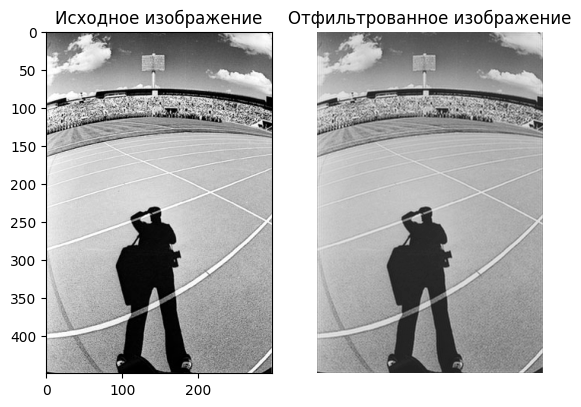

In [41]:
def apply_filter(signal1, h):
    return signal.fftconvolve(signal1, h, mode='same')

im = Image.open('var1.png').convert("L")
im = np.array(im)
print(im.shape)
filtered = np.zeros_like(im, dtype=float)
for i in range(im.shape[0]):
    filtered[i, :] = apply_filter(im[i,:],hh)

filtered2 = np.zeros_like(filtered, dtype=float)
for i in range(im.shape[1]):
    #filtered2[:, i] = filtfilt(h, 1, filtered[:, i])
    filtered2[:, i] = apply_filter(filtered[:,i],hh)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im,cmap = "gray")
plt.title("Исходное изображение")
plt.subplot(1, 2, 2)
plt.imshow(filtered2,cmap = "gray")
plt.title("Отфильтрованное изображение")
plt.axis('off')
plt.show()

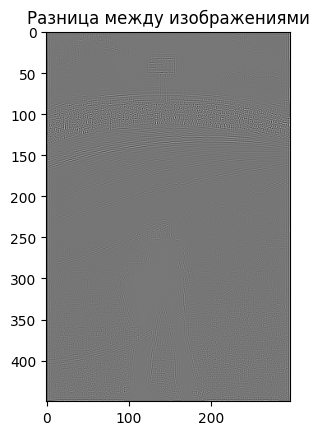

In [43]:
plt.figure()
plt.imshow(im-filtered2,cmap = "gray")
plt.title("Разница между изображениями")
plt.show()

------------------------------------------------------------------------------------------